# Phase 3 – Open-Vocabulary Detection (OWL-ViT & Grounding DINO)

This notebook explores **zero-shot, open-vocabulary object detection**  
using pretrained **OWL-ViT (Google Research)** and **Grounding DINO (IDEA Research)** models.  
Unlike YOLOv8 (closed-set), these models can detect **unseen or unlabeled maritime obstacles**  
based solely on natural-language prompts — without any fine-tuning.

---

**Pipeline**
1. Load pretrained OWL-ViT and Grounding DINO models  
2. Select evaluation images from **MODD** / **MODS** datasets  
3. Perform **text-prompted inference** (e.g., “boat”, “buoy”, “floating debris”, “dock”)  
4. Visualize detection results and store annotated outputs  
5. Prepare results for comparative evaluation (Notebook 04)

---

**Datasets**
- **MODD (Maritime Obstacle Detection Dataset):** Real ASV-mounted camera imagery with water reflections, wakes, and dynamic obstacles.  
- **MODS (Maritime Obstacle Detection from Stereo):** Stereo-pair sequences under varied weather and lighting, emphasizing long-range and partial-visibility targets.  

Both datasets serve as **open-world evaluation sets**, complementing the **MaSTr1325** dataset used earlier for YOLOv8 closed-set training.


### Environment Setup

In [1]:
# =====================================
# Notebook 03 — OWL-ViT & Grounding DINO
# Zero-Shot Open-Vocabulary Detection
# =====================================

import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

# Base directories (same as Notebook 02)
BASE_DIR = Path.cwd().parents[0]
DATA_DIR = BASE_DIR / "data"
VAL_IMAGES = DATA_DIR / "images" / "val"

RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

print("📁 Validation Images:", VAL_IMAGES)
print("📁 Results Directory:", RESULTS_DIR)
print("⚙️  Device:", device)


📁 Validation Images: d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val
📁 Results Directory: d:\Sem3\CS581B_Robot_Perception\Project\Implementation\results
⚙️  Device: cuda


### Load OWL-ViT Model

In [2]:
# =====================================
# 🦉 OWL-ViT Setup
# =====================================

from transformers import OwlViTProcessor, OwlViTForObjectDetection

OWL_MODEL = "google/owlvit-base-patch32"  # lightweight, GPU-friendly

processor_owl = OwlViTProcessor.from_pretrained(OWL_MODEL)
model_owl = OwlViTForObjectDetection.from_pretrained(
    OWL_MODEL,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
).to(device)

print(f"✅ OWL-ViT loaded on {device}")


d:\Sem3\CS581B_Robot_Perception\Project\Implementation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


✅ OWL-ViT loaded on cuda


### Define Inference function for OWL-ViT

In [3]:
def run_owlvit_inference(image_path, text_queries, threshold=0.15):
    """Run OWL-ViT zero-shot detection."""
    image = Image.open(image_path).convert("RGB")

    inputs = processor_owl(text=text_queries, images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model_owl(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor_owl.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

    # Filter by confidence threshold
    final_boxes = []
    final_scores = []
    final_labels = []

    for s, l, b in zip(results["scores"], results["labels"], results["boxes"]):
        if s >= threshold:
            final_boxes.append(b.cpu().numpy())
            final_scores.append(float(s))
            final_labels.append(int(l))

    return image, final_boxes, final_scores, final_labels


### Visualize OWL-ViT Detections

In [4]:
def visualize_owlvit(image, boxes, scores, labels, text_queries):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    ax = plt.gca()

    for box, score, label in zip(boxes, scores, labels):
        x0, y0, x1, y1 = box

        rect = plt.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            fill=False,
            edgecolor="lime",
            linewidth=2,
        )
        ax.add_patch(rect)

        caption = f"{text_queries[label]} {score:.2f}"
        ax.text(x0, y0, caption, color="yellow", fontsize=9,
                bbox=dict(facecolor="black", alpha=0.6))

    plt.axis("off")
    plt.show()


### Run OWL-ViT on Sample Images

🔹 Running OWL-ViT on 10 images...


  0%|          | 0/10 [00:00<?, ?it/s]d:\Sem3\CS581B_Robot_Perception\Project\Implementation\.venv\Lib\site-packages\transformers\models\owlvit\processing_owlvit.py:217: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


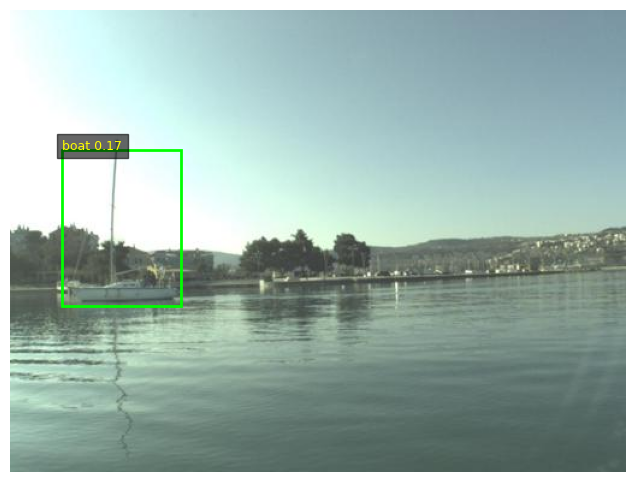

 10%|█         | 1/10 [00:00<00:05,  1.54it/s]

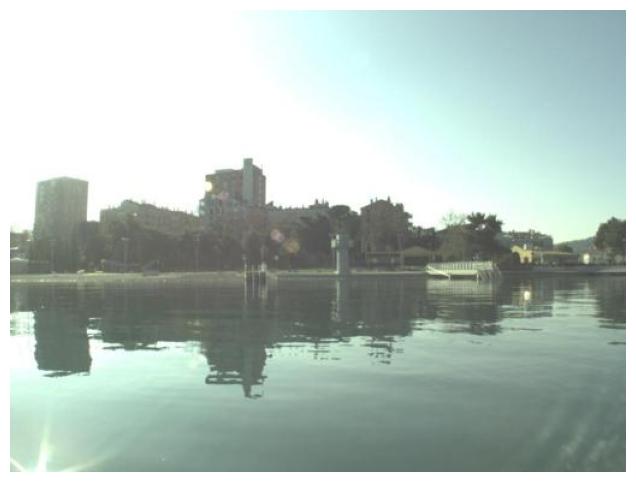

 20%|██        | 2/10 [00:00<00:02,  2.89it/s]

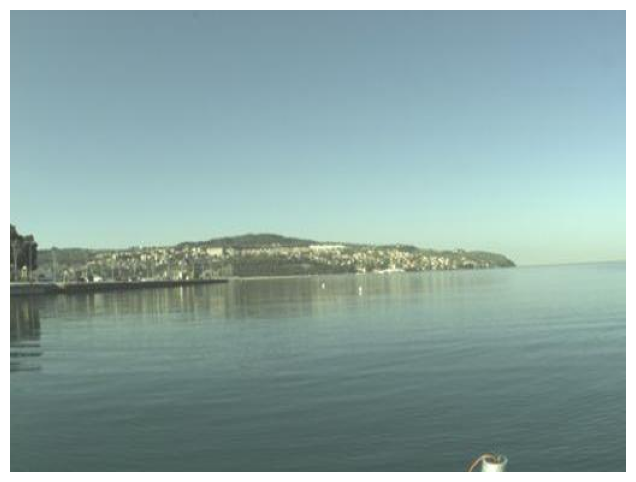

 30%|███       | 3/10 [00:00<00:01,  4.17it/s]

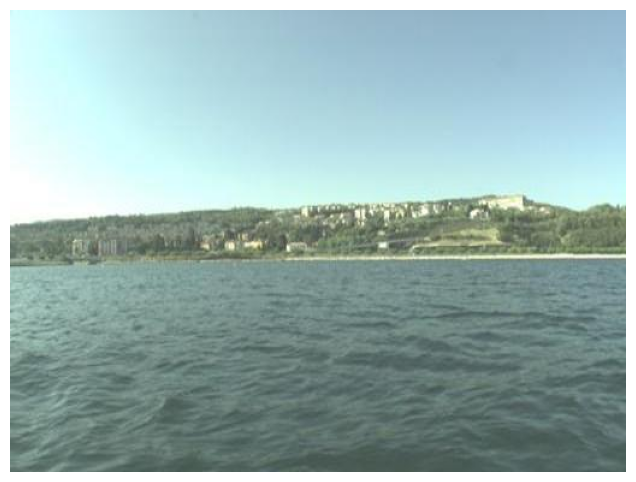

 40%|████      | 4/10 [00:01<00:01,  5.14it/s]

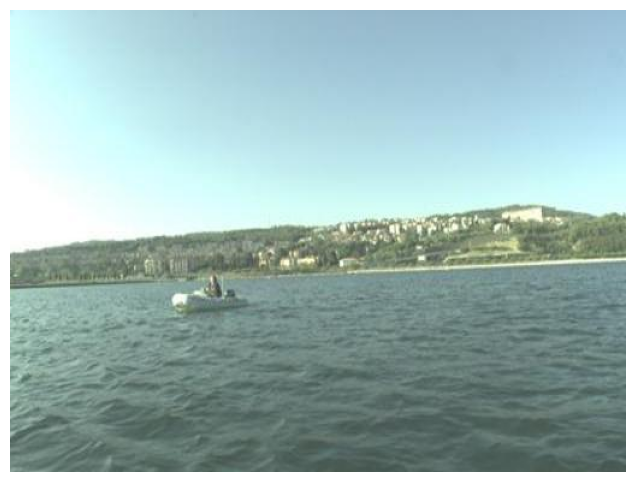

 50%|█████     | 5/10 [00:01<00:00,  6.03it/s]

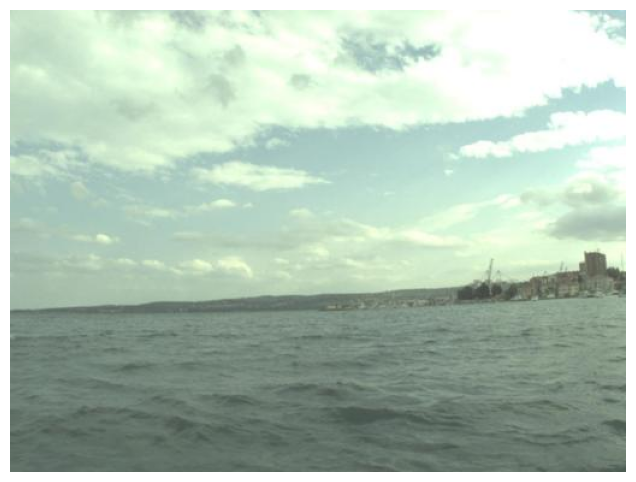

 60%|██████    | 6/10 [00:01<00:00,  6.64it/s]

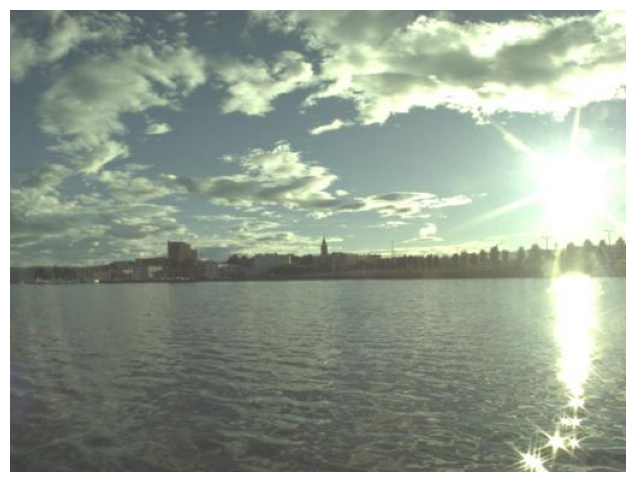

 70%|███████   | 7/10 [00:01<00:00,  6.97it/s]

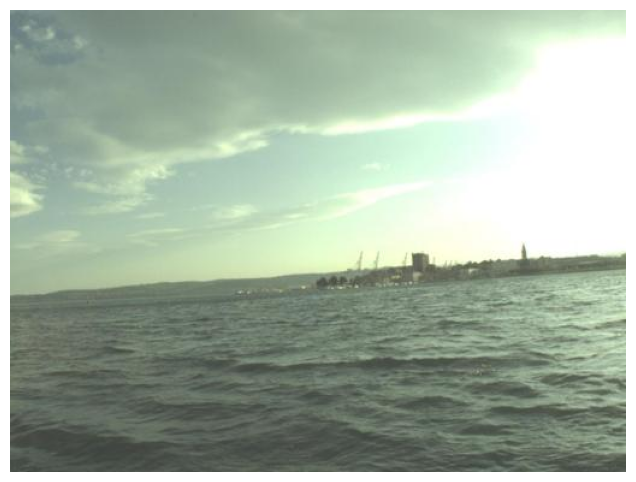

 80%|████████  | 8/10 [00:01<00:00,  7.31it/s]

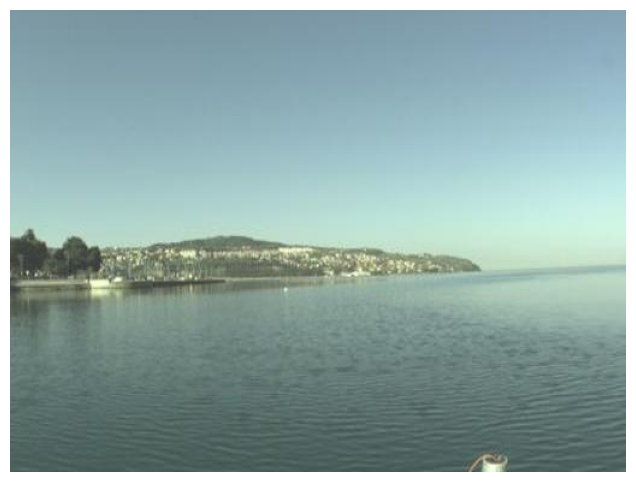

 90%|█████████ | 9/10 [00:01<00:00,  7.73it/s]

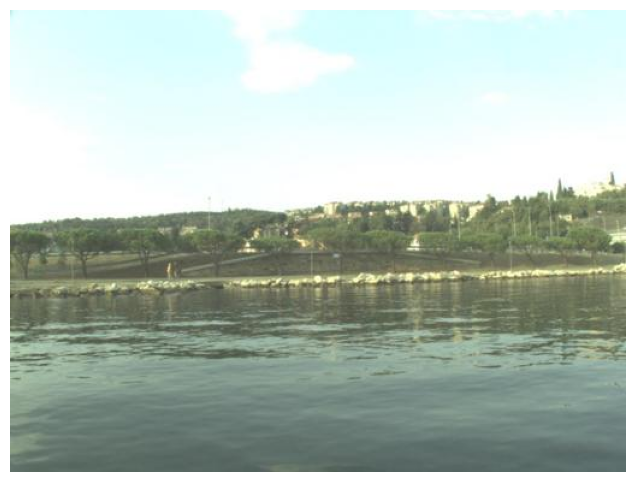

100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


In [5]:
queries = ["boat", "buoy", "dock", "obstacle", "floating debris", "person"]

sample_imgs = random.sample(sorted(list(VAL_IMAGES.glob("*.jpg"))), 10)


print(f"🔹 Running OWL-ViT on {len(sample_imgs)} images...")

for img_path in tqdm(sample_imgs):
    img, boxes, scores, labels = run_owlvit_inference(img_path, queries)
    visualize_owlvit(img, boxes, scores, labels, queries)

### OWL-ViT Zero-Shot Metrics Collector

In [6]:
import time
import json
import pandas as pd

def compute_owlvit_metrics(image_paths, text_queries, threshold=0.15):
    metrics_list = []

    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB")

        # Preprocess
        inputs = processor_owl(text=text_queries, images=image, return_tensors="pt").to(device)

        # Time inference
        start = time.time()
        with torch.no_grad():
            outputs = model_owl(**inputs)
        infer_time = time.time() - start

        # Post-process
        target_sizes = torch.tensor([image.size[::-1]]).to(device)
        result = processor_owl.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

        scores = result["scores"].cpu().numpy()
        labels = result["labels"].cpu().numpy()

        # Filter detections above confidence threshold
        valid_scores = scores[scores >= threshold]
        valid_labels = labels[scores >= threshold]

        # Build class frequency dict
        class_counts = {}
        for lbl in valid_labels:
            classname = text_queries[lbl]
            class_counts[classname] = class_counts.get(classname, 0) + 1

        # Create metrics for this image
        metrics = {
            "image": img_path.name,
            "num_detections": len(valid_scores),
            "avg_confidence": float(valid_scores.mean()) if len(valid_scores) else 0.0,
            "max_confidence": float(valid_scores.max()) if len(valid_scores) else 0.0,
            "detections_per_class": class_counts,
            "inference_time": infer_time
        }

        metrics_list.append(metrics)

    return metrics_list


### Run Metrics on Valiidation Images

In [7]:
import json
import pandas as pd

# Pick 30 images for evaluation
eval_images = list(VAL_IMAGES.glob("*.jpg"))[:30]

print(f"📊 Computing OWL-ViT metrics for {len(eval_images)} images...")

owlvit_metrics = compute_owlvit_metrics(eval_images, queries)

# Save metrics
metrics_path_json = RESULTS_DIR / "owlvit_metrics.json"
metrics_path_csv = RESULTS_DIR / "owlvit_metrics.csv"

with open(metrics_path_json, "w") as f:
    json.dump(owlvit_metrics, f, indent=4)

pd.DataFrame([owlvit_metrics]).to_csv(metrics_path_csv, index=False)

print("✅ OWL-ViT Metrics saved:")
print("JSON →", metrics_path_json)
print("CSV  →", metrics_path_csv)



📊 Computing OWL-ViT metrics for 30 images...
✅ OWL-ViT Metrics saved:
JSON → d:\Sem3\CS581B_Robot_Perception\Project\Implementation\results\owlvit_metrics.json
CSV  → d:\Sem3\CS581B_Robot_Perception\Project\Implementation\results\owlvit_metrics.csv


### Load Grounding DINO

In [8]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

# HuggingFace version — works on Windows!
DINO_MODEL = "IDEA-Research/grounding-dino-tiny"

processor_dino = AutoProcessor.from_pretrained(DINO_MODEL)

# FP32 AVOID mixed-precision crash on Windows
model_dino = AutoModelForZeroShotObjectDetection.from_pretrained(
    DINO_MODEL,
    torch_dtype=torch.float32
).to(device)

print("🦖 Grounding DINO-Tiny loaded successfully!")


Using: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


🦖 Grounding DINO-Tiny loaded successfully!


### Run Grounding DINO Interface

In [9]:
def run_dino(image_path, prompt, threshold=0.25):
    image = Image.open(image_path).convert("RGB")

    # Preprocess
    inputs = processor_dino(
        images=image,
        text=[prompt],
        return_tensors="pt"
    ).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model_dino(**inputs)

    # Post-process USING YOUR AVAILABLE FUNCTION
    results = processor_dino.post_process_grounded_object_detection(
        outputs,
        target_sizes=[image.size[::-1]]  # (H, W)
    )[0]

    return image, results


### Visualize GROUNDING DINO

In [10]:
def visualize_dino(image, results, prompt, threshold=0.25):
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"]   # <-- already Python strings

    plt.figure(figsize=(7, 6))
    plt.imshow(image)
    ax = plt.gca()

    for score, label, box in zip(scores, labels, boxes):
        if score < threshold:
            continue

        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1

        rect = plt.Rectangle(
            (x1, y1), w, h,
            fill=False, color="lime", linewidth=2
        )
        ax.add_patch(rect)

        ax.text(
            x1, y1,
            f"{label} {score:.2f}",
            color="yellow",
            fontsize=9,
            bbox=dict(facecolor="black", alpha=0.5)
        )

    plt.axis("off")
    plt.show()


### Run DINO on 5 Random Images

d:\Sem3\CS581B_Robot_Perception\Project\Implementation\.venv\Lib\site-packages\transformers\models\grounding_dino\processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


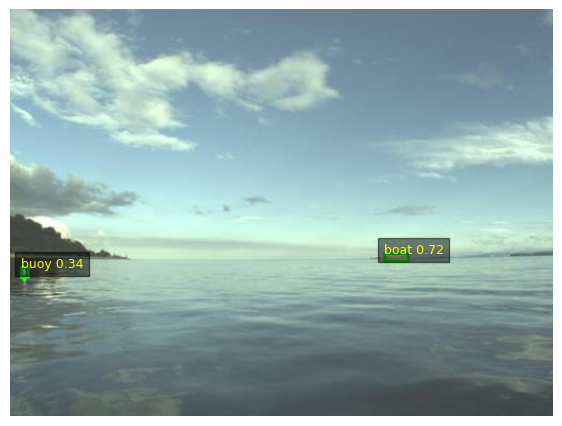

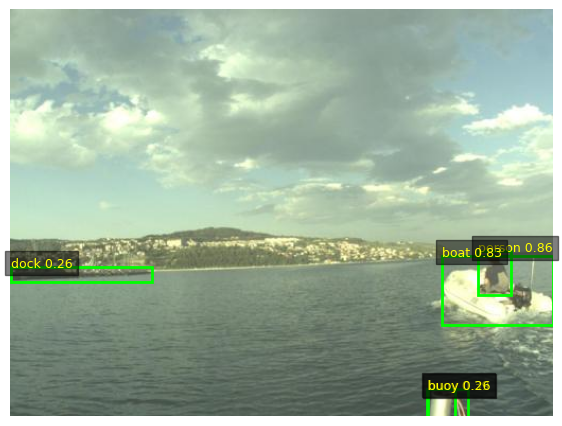

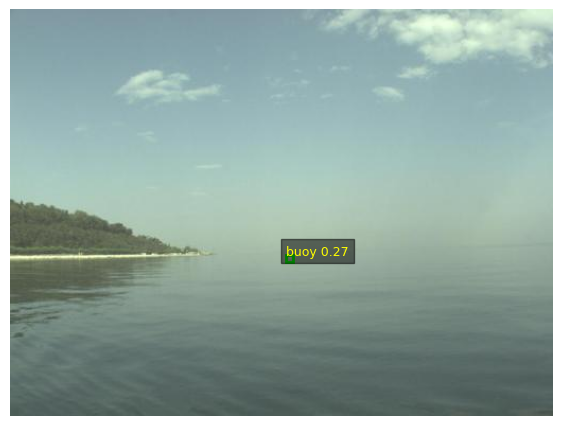

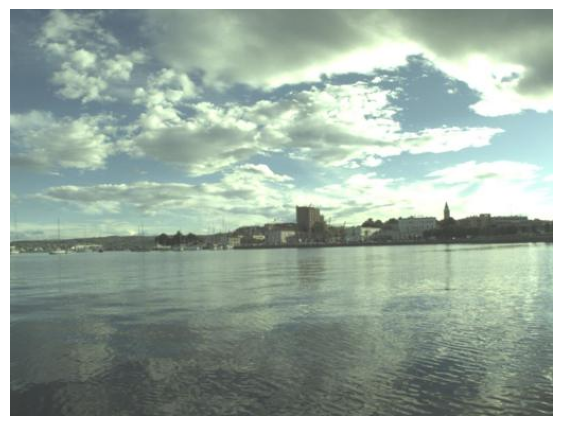

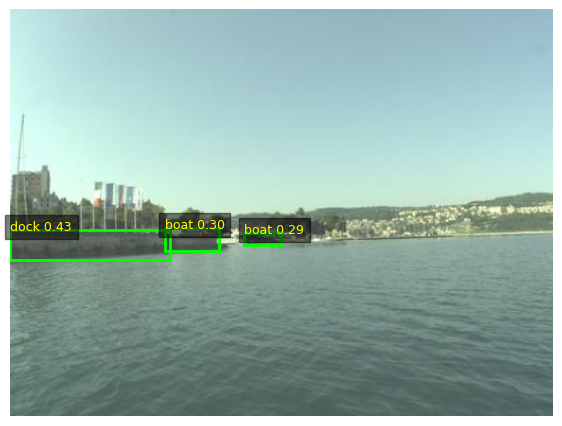

In [11]:
import random
from pathlib import Path

sample_imgs = random.sample(list(VAL_IMAGES.glob("*.jpg")), 5)

dino_prompt = "boat . buoy . dock . person . debris . obstacle"

for img_path in sample_imgs:
    image, results = run_dino(img_path, dino_prompt, threshold=0.20)
    visualize_dino(image, results, dino_prompt)


### Lightweight Metrics for GROUNDING DINO

In [12]:
def compute_dino_simple_metrics(image_list, prompt, threshold=0.25):
    metrics = {
        "num_images": len(image_list),
        "num_detections": 0,
        "avg_confidence": 0,
        "max_confidence": 0,
        "avg_inference_time_ms": 0
    }

    confs = []
    total_time = 0

    for img_path in tqdm(image_list):
        # Time measurement
        start = time.time()
        image, results = run_dino(img_path, prompt, threshold)
        infer_time = (time.time() - start) * 1000  # ms
        total_time += infer_time

        scores = results["scores"].cpu().tolist()
        metrics["num_detections"] += len(scores)
        confs.extend(scores)

    if confs:
        metrics["avg_confidence"] = float(np.mean(confs))
        metrics["max_confidence"] = float(np.max(confs))

    metrics["avg_inference_time_ms"] = total_time / len(image_list)
    return metrics


### Run DINO Metrics

In [13]:
eval_images = list(VAL_IMAGES.glob("*.jpg"))[:30]
print("📊 Running GroundingDINO simple metrics on 30 images...")

dino_metrics = compute_dino_simple_metrics(eval_images, dino_prompt)

print("GroundingDINO Metrics:")
print(dino_metrics)

📊 Running GroundingDINO simple metrics on 30 images...


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]

GroundingDINO Metrics:
{'num_images': 30, 'num_detections': 105, 'avg_confidence': 0.4501536891573951, 'max_confidence': 0.8883968591690063, 'avg_inference_time_ms': 597.8025754292806}


### Save Metrics

In [14]:
# OWL-ViT saves full per-image metrics (already correct above)
pd.DataFrame(owlvit_metrics).to_csv(RESULTS_DIR/"owlvit_metrics.csv", index=False)
with open(RESULTS_DIR/"owlvit_metrics.json", "w") as f:
    json.dump(owlvit_metrics, f, indent=4)

# Grounding DINO lightweight metrics
pd.DataFrame([dino_metrics]).to_csv(RESULTS_DIR/"groundingdino_metrics.csv", index=False)
with open(RESULTS_DIR/"groundingdino_metrics.json", "w") as f:
    json.dump(dino_metrics, f, indent=4)

print("✔ Metrics saved!")

✔ Metrics saved!
